In [1]:
%load_ext autoreload
# Enable autoreload for all modules
%autoreload 2

In [2]:
from iris_environments.environments import get_environment_builder, get_robot_instance_names
from cspace_utils.graphs import compute_greedy_clique_partition
from cspace_utils.plotting import (plot_cliques, 
                                   plot_visibility_graph, 
                                   plot_edges, 
                                   plot_points,
                                   plot_2d_ellipse_meshcat,
                                   plot_vpoly_2d_meshcat,
                                   plot_regions)
from cspace_utils.geometry import get_AABB_cvxhull
from cspace_utils.sampling import sample_in_union_of_polytopes
from misc.task_space_seeding_utils import task_space_sampler_mp, get_cvx_hulls_of_bodies
from cspace_utils.environment_helpers import get_col_func, get_coverage_estimator, get_sample_cfree_handle, vgraph
import numpy as np
import ipywidgets as widgets
from functools import partial
from pydrake.all import (RigidTransform, 
                         Rgba, 
                         Sphere, 
                         RotationMatrix, 
                         SceneGraphCollisionChecker,
                         HPolyhedron,
                         VPolytope)

In [3]:
from iris_environments.environments import env_names
currname = '7DOFBINS'
plant_builder = get_environment_builder(currname)
plant, scene_graph, diagram, diagram_context, plant_context, meshcat = plant_builder(usemeshcat=True)

scene_graph_context = scene_graph.GetMyMutableContextFromRoot(
    diagram_context)

rob_names = get_robot_instance_names(currname)
robot_instances = [plant.GetModelInstanceByName(n) for n in rob_names]
checker = SceneGraphCollisionChecker(model = diagram, 
                    robot_model_instances = robot_instances,
                    #configuration_distance_function = _configuration_distance,
                    edge_step_size = 0.125)

col_col =  Rgba(0.8, 0.0, 0, 0.5)    
col_free =  Rgba(0.0, 0.8, 0.5, 0.5) 

def showres(qvis):
    plant.SetPositions(plant_context, qvis)
    diagram.ForcedPublish(diagram_context)
    query = plant.get_geometry_query_input_port().Eval(plant_context)
    col = query.HasCollisions()
    if col:
        meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.2),
                                   col_col)
    else:
        meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.2),
                                   col_free)
    meshcat.SetTransform(f"/drake/visualizer/shunk",
                                   RigidTransform(RotationMatrix(),
                                                  np.array([0,0,2])))
    return col

INFO:drake:Meshcat listening for connections at http://localhost:7000


INFO:drake:Allocating contexts to support implicit context parallelism 20


In [4]:
col_hand=get_col_func(plant, plant_context, use_ik=False)
sample_cfree = get_sample_cfree_handle(plant.GetPositionLowerLimits(), 
                        plant.GetPositionUpperLimits(),
                        col_hand)

In [5]:
from pydrake.all import RandomGenerator
domain = HPolyhedron.MakeBox(plant.GetPositionLowerLimits(),
                             plant.GetPositionUpperLimits())

generator = RandomGenerator(0)
pt = domain.UniformSample(generator)
N = 100000
pts = []
for i in range(N):
    pt = domain.UniformSample(generator, pt)
    pts.append(pt)

import time
t1 = time.time()
checker.CheckConfigsCollisionFree(np.array(pts), parallelize=True)
t2 = time.time()
print(t2-t1)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-11
0.5637216567993164


In [6]:
from cspace_utils.colors import generate_distinct_colors
offset_size = 0.01
geom_names = ['bin_base', 
              'bin_base', 
              'shelves_body'
              ]
model_names = ['binL', 
               'binR', 
               'shelves'
               ]
default_pos = [np.array([ 1.53294,  0.4056 ,  0.23294, -0.5944 ,0.,0.9056 ,0.]),
               np.array([-1.53294,  0.4056 ,  0.23294, -0.5944 ,0.,  0.9056 ,0. ]),
               np.array([ 0., -0.08940423,  0., -1.7087849,  0., 1.32867852,  0.])
               ]
approach_dir = [2, 
                2, 
                0
                ] 
approach_sign = [1,1,-1]
ts_samplers = []
cols = generate_distinct_colors(2*len(model_names), rgb = True)[1:]
AABB_sampling_regions = []
for i, (g, m) in enumerate(zip(geom_names, model_names)):
    cvx_hulls_of_ROI_unsc, bodies = get_cvx_hulls_of_bodies([g], [m], plant, scene_graph, scene_graph_context, scaling = 1.0)
    verts = [VPolytope(c).vertices().T for c in cvx_hulls_of_ROI_unsc]
    cvx_hulls_of_ROI = cvx_hulls_of_ROI_unsc
    cvx_hulls_of_ROI = []
    for v in verts:
        offset = approach_sign[i]*(np.sign(v[:,approach_dir[i]] - np.mean(v[:,approach_dir[i]]))==approach_sign[i])*offset_size
        v[:,approach_dir[i]] += offset #scale*(v[:,approach_dir[i]] - np.mean(v[:,approach_dir[i]])) +  np.mean(v[:,approach_dir[i]])
        cvx_hulls_of_ROI.append(HPolyhedron(VPolytope(v.T)))
    ts_min, ts_max, cvxh_hpoly = get_AABB_cvxhull(cvx_hulls_of_ROI)
    AABB_sampling_regions.append([ts_min, ts_max])
    plot_regions(meshcat, cvx_hulls_of_ROI, region_suffix=m,opacity=0.2, colors=[cols[i]])
    q0  = default_pos[i] #np.zeros(7)
    plant.SetPositions(plant_context, q0)
    plant.ForcedPublish(plant_context)
    showres(q0)
    t0 = plant.EvalBodyPoseInWorld(plant_context,  plant.GetBodyByName("body")).translation()       
    sample_handle_ts = partial(task_space_sampler_mp,
                            q0 = q0,
                            t0 = t0,
                            plant_builder = plant_builder,
                            frame_names = ['body'],
                            offsets = [np.array([0,0.1,0])],
                            cvx_hulls_of_ROI =cvx_hulls_of_ROI,
                            ts_min = ts_min,
                            ts_max = ts_max,
                            collision_free = True,
                            track_orientation = True,
                            axis_alignment = None#approach_dir[i]
                            )
    ts_samplers.append(sample_handle_ts)

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coeffici

In [7]:
from pydrake.all import SceneGraphCollisionChecker
from cspace_utils.graphs import vgraph, compute_greedy_clique_partition

robot_instances = [plant.GetModelInstanceByName("iiwa"), plant.GetModelInstanceByName("wsg")]
vgraph_handle = partial(vgraph, checker = checker, parallelize = True) 

In [8]:
import os 
import pickle
from cspace_utils.graphs import compute_double_greedy_clique_partition

Npts = 1000
seed = 5
if f"7DOFBINS_{Npts}_{offset_size}_{seed}.pkl" in os.listdir('../tmp'):
    with open(f"../tmp/7DOFBINS_{Npts}_{offset_size}_{seed}.pkl", 'rb') as f:
        d = pickle.load(f)
        q_obj = d['q_obj']
        t_obj = d['t_obj']
        q_tot = d['q_tot']
        t_tot = d['t_tot']        
        ad_mat = d['ad_obj']
        ad_tot = d['ad_tot']
        cliques_obj = d['cliques_obj']
        cliques_tot = d['cliques_tot']
else:
    q_obj = []
    t_obj = []
    ad_obj = []
    cliques_obj = []
    for sh in ts_samplers:
        q, t, _, res = sh(Npts,[])
        ad_mat = vgraph_handle(q)
        q_obj +=[q]
        t_obj +=[t]
        ad_obj +=[ad_mat]
        cliques_obj += [compute_double_greedy_clique_partition(adj_mat=ad_mat.toarray(), min_cliuqe_size=10)]
    t_tot = np.concatenate(tuple(t_obj))
    q_tot = np.concatenate(tuple(q_obj))
    ad_tot = vgraph_handle(np.concatenate(tuple(q_obj), axis= 0))
    #cliques_tot = compute_greedy_clique_partition(ad_tot.toarray(), min_cliuqe_size=10)
    cliques_tot = compute_double_greedy_clique_partition(ad_tot.toarray(), min_cliuqe_size=10)
    with open(f"../tmp/7DOFBINS_{Npts}_{offset_size}_{seed}.pkl", 'wb') as f:
        pickle.dump({'q_obj':q_obj, 
                     't_obj':t_obj, 
                     't_tot': t_tot, 
                     'q_tot': q_tot, 
                     'ad_obj': ad_obj, 
                     'ad_tot' : ad_tot,
                     'cliques_obj': cliques_obj, 
                     'cliques_tot': cliques_tot}, f)

In [9]:
#check if cliques are geometric cliques
from cspace_utils.graphs import is_geometric_clique

for obj in range(len(cliques_obj)):
    pts_ =q_obj[obj]
    vgraph_ = ad_mat[obj]
    for clique_idx, clique_ in enumerate(cliques_obj[obj]):
        if len(clique_)>14:
            res, num_violators, violators = is_geometric_clique(clique_, pts_, vgraph=vgraph_, return_violators=True)
            print(f"Object: {obj} Clique: {clique_idx} CliqueSize: { len(clique_)} Geometric clique {res} #violators {num_violators}")

Object: 0 Clique: 0 CliqueSize: 234 Geometric clique True #violators 0
Object: 0 Clique: 1 CliqueSize: 67 Geometric clique True #violators 0
Object: 0 Clique: 2 CliqueSize: 53 Geometric clique True #violators 0
Object: 0 Clique: 3 CliqueSize: 46 Geometric clique False #violators 1
Object: 0 Clique: 4 CliqueSize: 33 Geometric clique True #violators 0
Object: 0 Clique: 5 CliqueSize: 39 Geometric clique True #violators 0
Object: 0 Clique: 6 CliqueSize: 43 Geometric clique True #violators 0
Object: 0 Clique: 7 CliqueSize: 34 Geometric clique True #violators 0
Object: 0 Clique: 8 CliqueSize: 35 Geometric clique True #violators 0
Object: 0 Clique: 9 CliqueSize: 18 Geometric clique True #violators 0
Object: 0 Clique: 10 CliqueSize: 19 Geometric clique True #violators 0
Object: 0 Clique: 15 CliqueSize: 15 Geometric clique True #violators 0
Object: 0 Clique: 16 CliqueSize: 15 Geometric clique True #violators 0
Object: 0 Clique: 18 CliqueSize: 18 Geometric clique True #violators 0
Object: 1 Cliq

In [10]:
from pydrake.all import FastIris, FastIrisOptions, Hyperellipsoid, RandomGenerator

generator = RandomGenerator(seed)
fio = FastIrisOptions()
fio.admissible_proportion_in_collision = 0.01
fio.target_uncertainty = 0.01
fio.max_iterations = 1
fio.num_particles = 1000
fio.configuration_space_margin = 0.01
fio.verbose = True
fio.random_seed = seed
domain = HPolyhedron.MakeBox(plant.GetPositionLowerLimits(),
                             plant.GetPositionUpperLimits())

In [11]:
regions_obj_no_containment = []
regions_obj_containment = []
for obj in range(len(ts_samplers)):
    regs_no_containment = []
    regs_containment = []
    clique_pts_t_obj = [np.array([t_obj[obj][i, :] for i in cl]) for cl in cliques_obj[obj]]
    clique_pts_loc = [np.array([q_obj[obj][i, :] for i in cl]) for cl in cliques_obj[obj]]
    for clique_pts in clique_pts_loc:
        fio.containment_points = clique_pts.T
        try:
            if len(clique_pts) > 10:
                seed_ellipse = Hyperellipsoid.MinimumVolumeCircumscribedEllipsoid(clique_pts.T)
                print(f"Ellipsoid center collision free {checker.CheckConfigCollisionFree(seed_ellipse.center())}")
                assert checker.CheckConfigCollisionFree(seed_ellipse.center())
                fio.force_containment_points = False
                reg_no_cont = FastIris(checker, seed_ellipse, domain, fio)
                fio.force_containment_points = True
                reg_cont = FastIris(checker, seed_ellipse, domain, fio)
                regs_no_containment += [reg_no_cont]
                regs_containment += [reg_cont]
        except:
            print("region generation failed")
    regions_obj_no_containment += [regs_no_containment]
    regions_obj_containment += [regs_containment]

INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0


Ellipsoid center collision free True


INFO:drake:SeparatingPlanes iteration: 1 faces: 24
INFO:drake:FastIris iter 1, iter limit 1
INFO:drake:Fast Iris execution time : 1661 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:FastIris Warning relaxing cspace margin by 0.007481234538335713 to ensure point containment
INFO:drake:SeparatingPlanes iteration: 1 faces: 24
INFO:drake:FastIris Warning relaxing cspace margin by 0.007481234538335713 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.007481234538335713 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.007481234538335713 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.007481234538335713 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.007481234538335713 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.007481234538335713 to ensure point 

Ellipsoid center collision free True


INFO:drake:FastIris iter 1, iter limit 1
INFO:drake:Fast Iris execution time : 508 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 22
INFO:drake:FastIris Warning relaxing cspace margin by 1.8279957017193116 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 1.8279957017193116 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 1.8279957017193116 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 1.8279957017193116 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 1.8279957017193116 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 1.8279957017193116 to ensure point containment
INFO:drake:FastIris iter 1, iter limit 1
INFO:drake:Fast Iris execution time : 719 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 

Ellipsoid center collision free True


INFO:drake:FastIris iter 1, iter limit 1
INFO:drake:Fast Iris execution time : 510 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 25
INFO:drake:FastIris Warning relaxing cspace margin by 0.004865206111004161 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.004865206111004161 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.004865206111004161 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.004865206111004161 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.004865206111004161 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.004865206111004161 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.004865206111004161 to ensure point containment
INFO:drake:FastIris iter 1, iter limit 1

Ellipsoid center collision free True


INFO:drake:FastIris iter 1, iter limit 1
INFO:drake:Fast Iris execution time : 220 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:FastIris Warning relaxing cspace margin by 0.010103366429594196 to ensure point containment
INFO:drake:SeparatingPlanes iteration: 1 faces: 20
INFO:drake:FastIris Warning relaxing cspace margin by 0.010103366429594196 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.010103366429594196 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.010103366429594196 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.010103366429594196 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.010103366429594196 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.010103366429594196 to ensure point containment
INFO:drake:FastIris Warning relaxing csp

Ellipsoid center collision free True


INFO:drake:Fast Iris execution time : 449 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:FastIris Warning relaxing cspace margin by 0.006185579386481566 to ensure point containment
INFO:drake:SeparatingPlanes iteration: 1 faces: 20
INFO:drake:FastIris Warning relaxing cspace margin by 0.008419518754900324 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008419518754900324 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008419518754900324 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008419518754900324 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008419518754900324 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008419518754900324 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008419518754900324 to ens

Ellipsoid center collision free True


INFO:drake:Fast Iris execution time : 344 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:FastIris Warning relaxing cspace margin by 0.005799856062659314 to ensure point containment
INFO:drake:SeparatingPlanes iteration: 1 faces: 24
INFO:drake:FastIris Warning relaxing cspace margin by 0.005799856062659314 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009701717581430541 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009701717581430541 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009701717581430541 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009701717581430541 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009701717581430541 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009701717581430541 to ens

Ellipsoid center collision free True


INFO:drake:FastIris delta vol 0.014009771545346134, threshold 0.02
INFO:drake:Fast Iris execution time : 476 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:FastIris Warning relaxing cspace margin by 0.006904404174891798 to ensure point containment
INFO:drake:SeparatingPlanes iteration: 1 faces: 26
INFO:drake:FastIris Warning relaxing cspace margin by 0.006904404174891798 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.006904404174891798 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.006904404174891798 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.006904404174891798 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.006904404174891798 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.006904404174891798 to ensure point containment
INFO:drake:Fas

Ellipsoid center collision free True


INFO:drake:FastIris delta vol 0.013753612666601363, threshold 0.02
INFO:drake:Fast Iris execution time : 275 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:FastIris Warning relaxing cspace margin by 0.0016480367103759441 to ensure point containment
INFO:drake:SeparatingPlanes iteration: 1 faces: 22
INFO:drake:FastIris Warning relaxing cspace margin by 0.008619181470821191 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008619181470821191 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008619181470821191 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008619181470821191 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008619181470821191 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008619181470821191 to ensure point containment
INFO:drake:Fa

Ellipsoid center collision free True


INFO:drake:FastIris delta vol 0.01212270974723403, threshold 0.02
INFO:drake:Fast Iris execution time : 288 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 22
INFO:drake:FastIris Warning relaxing cspace margin by 0.008095222466324437 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008095222466324437 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009173124829280566 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009173124829280566 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.00959306194904308 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.00959306194904308 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.00959306194904308 to ensure point containment
INFO:drake:FastIri

Ellipsoid center collision free True


INFO:drake:FastIris delta vol 0.015589782347656943, threshold 0.02
INFO:drake:Fast Iris execution time : 487 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 22
INFO:drake:FastIris Warning relaxing cspace margin by 0.009083891286900236 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009918480014246445 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009918480014246445 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009918480014246445 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009918480014246445 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009918480014246445 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009918480014246445 to ensure point containment
INFO:drake:Fas

Ellipsoid center collision free True


INFO:drake:Fast Iris execution time : 417 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:FastIris Warning relaxing cspace margin by 0.00933228883155135 to ensure point containment
INFO:drake:SeparatingPlanes iteration: 1 faces: 23
INFO:drake:FastIris Warning relaxing cspace margin by 0.00933228883155135 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.00933228883155135 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.00933228883155135 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.00933228883155135 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.00933228883155135 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.00933228883155135 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.00933228883155135 to ensure poin

Ellipsoid center collision free True


INFO:drake:Fast Iris execution time : 472 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:FastIris Warning relaxing cspace margin by 0.008420516454020754 to ensure point containment
INFO:drake:SeparatingPlanes iteration: 1 faces: 19
INFO:drake:FastIris Warning relaxing cspace margin by 0.008420516454020754 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008420516454020754 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008420516454020754 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008420516454020754 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008420516454020754 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008420516454020754 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008420516454020754 to ens

Ellipsoid center collision free True


INFO:drake:FastIris delta vol 0.0008229021105964322, threshold 0.02
INFO:drake:Fast Iris execution time : 260 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:FastIris Warning relaxing cspace margin by 0.007615036787488608 to ensure point containment
INFO:drake:SeparatingPlanes iteration: 1 faces: 19
INFO:drake:FastIris Warning relaxing cspace margin by 0.007615036787488608 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.007615036787488608 to ensure point containment
INFO:drake:FastIris iter 1, iter limit 1
INFO:drake:Fast Iris execution time : 150 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 21
INFO:drake:FastIris delta vol 0.0009073852891691926, threshold 0.02


Ellipsoid center collision free True


INFO:drake:Fast Iris execution time : 346 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:FastIris Warning relaxing cspace margin by 0.006900681587289181 to ensure point containment
INFO:drake:SeparatingPlanes iteration: 1 faces: 22
INFO:drake:FastIris Warning relaxing cspace margin by 0.006900681587289181 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.006900681587289181 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008962331678164404 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008962331678164404 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008962331678164404 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008962331678164404 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008962331678164404 to ens

Ellipsoid center collision free True


INFO:drake:Fast Iris execution time : 386 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 18
INFO:drake:FastIris Warning relaxing cspace margin by 0.009150250569394558 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009150250569394558 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009150250569394558 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009150250569394558 to ensure point containment
INFO:drake:FastIris delta vol 0.0022427099274527633, threshold 0.02
INFO:drake:Fast Iris execution time : 519 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 23


Ellipsoid center collision free True


INFO:drake:FastIris iter 1, iter limit 1
INFO:drake:Fast Iris execution time : 425 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:FastIris Warning relaxing cspace margin by 0.0003394738353696969 to ensure point containment
INFO:drake:SeparatingPlanes iteration: 1 faces: 26
INFO:drake:FastIris Warning relaxing cspace margin by 0.0003394738353696969 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.006762751869036965 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.006762751869036965 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.006762751869036965 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.006762751869036965 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.006762751869036965 to ensure point containment
INFO:drake:FastIris Warning relaxing c

Ellipsoid center collision free True


INFO:drake:FastIris iter 1, iter limit 1
INFO:drake:Fast Iris execution time : 465 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 32
INFO:drake:FastIris Warning relaxing cspace margin by 0.0099245987061648 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.0099245987061648 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.015317527806480769 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.015317527806480769 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.015317527806480769 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.015317527806480769 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.015317527806480769 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace 

Ellipsoid center collision free True


INFO:drake:Fast Iris execution time : 252 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 27
INFO:drake:FastIris Warning relaxing cspace margin by 0.004170718624921965 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.004170718624921965 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.004170718624921965 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008975625123918918 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008990479230875925 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.0099889057379281 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.0099889057379281 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.0099889057379281 to ensure po

Ellipsoid center collision free True


INFO:drake:Fast Iris execution time : 319 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:FastIris Warning relaxing cspace margin by 0.03304744844353913 to ensure point containment
INFO:drake:SeparatingPlanes iteration: 1 faces: 24
INFO:drake:FastIris Warning relaxing cspace margin by 0.03304744844353913 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.03304744844353913 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.03304744844353913 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.03304744844353913 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.03304744844353913 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.03304744844353913 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.03304744844353913 to ensure poin

Ellipsoid center collision free True


INFO:drake:Fast Iris execution time : 284 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 31
INFO:drake:FastIris Warning relaxing cspace margin by 0.004606617426803794 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009733953217835212 to ensure point containment
INFO:drake:FastIris iter 1, iter limit 1
INFO:drake:Fast Iris execution time : 577 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 25
INFO:drake:FastIris iter 1, iter limit 1


Ellipsoid center collision free True


INFO:drake:Fast Iris execution time : 461 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:FastIris Warning relaxing cspace margin by 0.7353613004403086 to ensure point containment
INFO:drake:SeparatingPlanes iteration: 1 faces: 23
INFO:drake:FastIris Warning relaxing cspace margin by 0.7353613004403086 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.7353613004403086 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.7353613004403086 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.7353613004403086 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.7353613004403086 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.7353613004403086 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.7353613004403086 to ensure point contai

Ellipsoid center collision free True


INFO:drake:FastIris iter 1, iter limit 1
INFO:drake:Fast Iris execution time : 476 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 28
INFO:drake:FastIris Warning relaxing cspace margin by 0.0018184146903716947 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.0018184146903716947 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.0018184146903716947 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.0018184146903716947 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.0018184146903716947 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.0018184146903716947 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.0018184146903716947 to ensure point containment
INFO:drake:FastIris delta vol 0.0

Ellipsoid center collision free True


INFO:drake:FastIris delta vol 0.008355310981038772, threshold 0.02
INFO:drake:Fast Iris execution time : 789 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:FastIris Warning relaxing cspace margin by 0.005615684643398122 to ensure point containment
INFO:drake:SeparatingPlanes iteration: 1 faces: 24
INFO:drake:FastIris Warning relaxing cspace margin by 0.005615684643398122 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.005615684643398122 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009989692800570937 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009989692800570937 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009989692800570937 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009989692800570937 to ensure point containment
INFO:drake:Fas

Ellipsoid center collision free True


INFO:drake:FastIris delta vol 0.01645599985314906, threshold 0.02
INFO:drake:Fast Iris execution time : 381 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:FastIris Warning relaxing cspace margin by 0.009327618163500473 to ensure point containment
INFO:drake:SeparatingPlanes iteration: 1 faces: 20
INFO:drake:FastIris Warning relaxing cspace margin by 0.009327618163500473 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009327618163500473 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009327618163500473 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009327618163500473 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009327618163500473 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009327618163500473 to ensure point containment
INFO:drake:Fast

Ellipsoid center collision free True


INFO:drake:FastIris delta vol 0.003603271683255496, threshold 0.02
INFO:drake:Fast Iris execution time : 560 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 20
INFO:drake:FastIris Warning relaxing cspace margin by 0.0003496566970793147 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.0003496566970793147 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009839840130845046 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009839840130845046 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009839840130845046 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009839840130845046 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009839840130845046 to ensure point containment
INFO:drake:F

Ellipsoid center collision free True


INFO:drake:Fast Iris execution time : 567 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:FastIris Warning relaxing cspace margin by 0.004317361291655608 to ensure point containment
INFO:drake:SeparatingPlanes iteration: 1 faces: 26
INFO:drake:FastIris Warning relaxing cspace margin by 0.004317361291655608 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.004317361291655608 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.005860150967898825 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.005860150967898825 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.005860150967898825 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008776320391253853 to ensure point containment
INFO:drake:FastIris delta vol 0.00031979380848059087, threshold 0.02
INFO:drake:F

Ellipsoid center collision free True


INFO:drake:Fast Iris execution time : 583 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 18
INFO:drake:FastIris Warning relaxing cspace margin by 0.0031203762460223494 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009347061855083494 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009347061855083494 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009347061855083494 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009347061855083494 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009347061855083494 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009347061855083494 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009347061855083494 to en

Ellipsoid center collision free True


INFO:drake:Fast Iris execution time : 611 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 18
INFO:drake:FastIris Warning relaxing cspace margin by 0.007835176563620927 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.007835176563620927 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.007835176563620927 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.00931294815602629 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.00931294815602629 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.00931294815602629 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.00931294815602629 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.00931294815602629 to ensure p

Ellipsoid center collision free True


INFO:drake:FastIris delta vol 3.149516903190469e-05, threshold 0.02
INFO:drake:Fast Iris execution time : 373 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:FastIris Warning relaxing cspace margin by 0.002886479692005506 to ensure point containment
INFO:drake:SeparatingPlanes iteration: 1 faces: 19
INFO:drake:FastIris Warning relaxing cspace margin by 0.007645656443077131 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009025840376342575 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009025840376342575 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009025840376342575 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009025840376342575 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009025840376342575 to ensure point containment
INFO:drake:Fa

Ellipsoid center collision free True


INFO:drake:FastIris delta vol 0.0026463673427513123, threshold 0.02
INFO:drake:Fast Iris execution time : 438 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 20
INFO:drake:FastIris Warning relaxing cspace margin by 0.008862278027801596 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008862278027801596 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009858134669118446 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009858134669118446 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009858134669118446 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009858134669118446 to ensure point containment
INFO:drake:FastIris delta vol 0.00026233283323861677, threshold 0.02
INFO:drake:Fast Iris execution time : 629 ms
IN

Ellipsoid center collision free True


INFO:drake:Fast Iris execution time : 549 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 20
INFO:drake:FastIris Warning relaxing cspace margin by 0.0020767808897133033 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.004172036411286273 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009190164947809887 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009190164947809887 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009190164947809887 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009190164947809887 to ensure point containment
INFO:drake:FastIris delta vol 0.0076533897602200545, threshold 0.02
INFO:drake:Fast Iris execution time : 482 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 


Ellipsoid center collision free True


INFO:drake:Fast Iris execution time : 337 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 27
INFO:drake:FastIris Warning relaxing cspace margin by 0.003021125745834796 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.007903098802434116 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.007903098802434116 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.007903098802434116 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009454831280356624 to ensure point containment
INFO:drake:FastIris delta vol 0.00013931752178461407, threshold 0.02
INFO:drake:Fast Iris execution time : 668 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 23


Ellipsoid center collision free True


INFO:drake:FastIris iter 1, iter limit 1
INFO:drake:Fast Iris execution time : 537 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 23
INFO:drake:FastIris Warning relaxing cspace margin by 0.002763047562826859 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.002763047562826859 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.002763047562826859 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.002763047562826859 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.00301318486252522 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009404654196995432 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009404654196995432 to ensure point containment
INFO:drake:FastIris iter 1, iter limit 1


Ellipsoid center collision free True


INFO:drake:Fast Iris execution time : 301 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 24
INFO:drake:FastIris Warning relaxing cspace margin by 0.006883951129466492 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.006883951129466492 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.006883951129466492 to ensure point containment
INFO:drake:FastIris iter 1, iter limit 1
INFO:drake:Fast Iris execution time : 330 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 22
INFO:drake:FastIris iter 1, iter limit 1


Ellipsoid center collision free True


INFO:drake:Fast Iris execution time : 261 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 21
INFO:drake:FastIris Warning relaxing cspace margin by 0.0038940326088949817 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.0038940326088949817 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.0038940326088949817 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.0038940326088949817 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.0038940326088949817 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.0038940326088949817 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.0038940326088949817 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.003894032608894981

Ellipsoid center collision free True


INFO:drake:FastIris iter 1, iter limit 1
INFO:drake:Fast Iris execution time : 313 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 20
INFO:drake:FastIris Warning relaxing cspace margin by 0.004221882250158071 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.005094879758619442 to ensure point containment
INFO:drake:FastIris iter 1, iter limit 1
INFO:drake:Fast Iris execution time : 232 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 22
INFO:drake:FastIris iter 1, iter limit 1


Ellipsoid center collision free True


INFO:drake:Fast Iris execution time : 575 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 22
INFO:drake:FastIris Warning relaxing cspace margin by 0.009411936180454106 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009411936180454106 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009411936180454106 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009411936180454106 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009411936180454106 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009411936180454106 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009411936180454106 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009411936180454106 to ens

Ellipsoid center collision free True


INFO:drake:FastIris delta vol 0.010206739270311762, threshold 0.02
INFO:drake:Fast Iris execution time : 517 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 24
INFO:drake:FastIris Warning relaxing cspace margin by 0.013459063078958278 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.013459063078958278 to ensure point containment
INFO:drake:FastIris delta vol 0.00950988713013504, threshold 0.02
INFO:drake:Fast Iris execution time : 552 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 18


region generation failed
Ellipsoid center collision free True


INFO:drake:FastIris delta vol 0.003274962319595595, threshold 0.02
INFO:drake:Fast Iris execution time : 473 ms
INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 18
INFO:drake:FastIris Warning relaxing cspace margin by 0.0006091618343331828 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008408849386176698 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008408849386176698 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.008408849386176698 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009149900221559482 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009149900221559482 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009149900221559482 to ensure point containment
INFO:drake:Fa

Text(0.5, 1.0, 'connectivity')

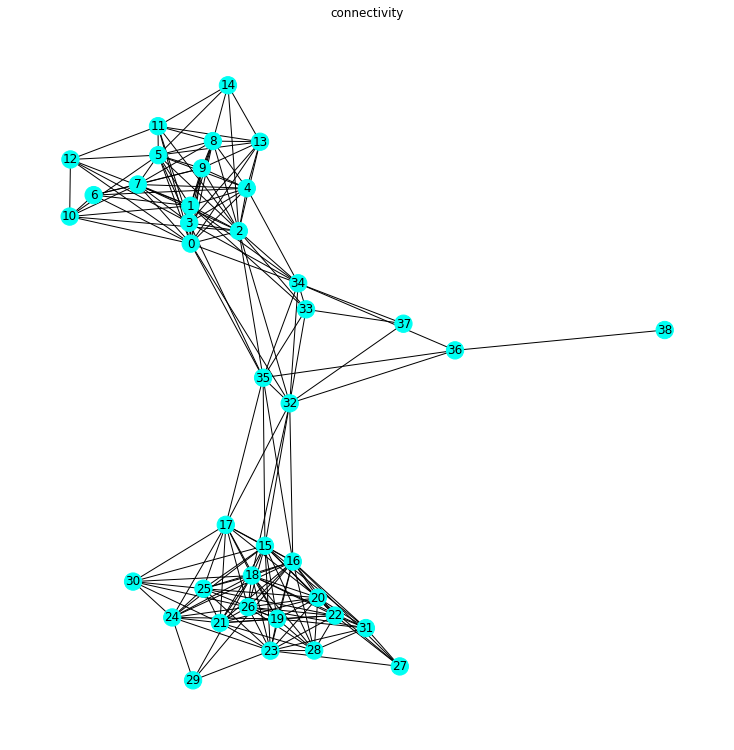

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

regionsFPP = []
for r in regions_obj_no_containment:
    regionsFPP += r 


connectivity_graph = nx.Graph()
for idx in range(len(regionsFPP)):
    connectivity_graph.add_node(idx)

for idx1 in range(len(regionsFPP)):
    for idx2 in range(idx1 +1, len(regionsFPP)):
        r1 = regionsFPP[idx1]
        r2 = regionsFPP[idx2]
        if r1.IntersectsWith(r2):
            connectivity_graph.add_edge(idx1,idx2)

fig = plt.figure(figsize=(10,10))
hues = generate_distinct_colors(2+1)[1:]
colors = []
for g, h in zip([regionsFPP], hues):
    colors += [h]*len(g)
nx.draw_spring(connectivity_graph, 
                with_labels = True, 
                node_color = colors)
plt.title(f"connectivity")

In [13]:
Ntest = 100
q_test_obj = []
t_test_obj = []
for sh in ts_samplers:
    q, t, _, res = sh(Ntest,[])
    q_test_obj += [q]
    t_test_obj += [t]

100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


In [23]:
from cspace_utils.sampling import point_in_regions
q_test_tot = np.concatenate(tuple(qs for qs in q_test_obj), axis=0)
t_test_tot = np.concatenate(tuple(qs for qs in q_test_obj), axis=0)

out_set = 0
for q in q_test_tot:
    if not point_in_regions(q, regionsFPP):
        out_set +=1

print(f"Containment {out_set}/{len(q_test_tot)}")

Containment 247/300


In [19]:
len(q_test_obj)

3

In [ ]:
from cspace_utils.pathplanning import DijkstraSPP

dspp = DijkstraSPP(regionsFPP, checker, verbose=True)

[DijkstraSPP] Pre-Building adjacency matrix  0 / 23
[DijkstraSPP] Pre-Building adjacency matrix  10 / 23
[DijkstraSPP] Pre-Building adjacency matrix  20 / 23
[DijkstraSPP] Pre-Building safe-adjacency matrix  0 / 23
[DijkstraSPP] Pre-Building safe-adjacency matrix  10 / 23
[DijkstraSPP] Pre-Building safe-adjacency matrix  20 / 23
[DijkstraSPP] Optimizing 55 point locations in safe sets
True


In [15]:
reg = HPolyhedron(VPolytope(clique_pts.T))

In [17]:
reg.MaximumVolumeInscribedEllipsoid().CalcVolume()

2.6166841926994497e-09

In [34]:
#t_tot = np.concatenate(tuple(t_obj))
obj = 0
clique_pts_t_obj = [np.array([t_obj[obj][i, :] for i in cl]) for cl in cliques_obj[obj]]
clique_pts_obj = [np.array([q_obj[obj][i, :] for i in cl]) for cl in cliques_obj[obj]]

clique_pts_t = [np.array([t_tot[i, :] for i in cl]) for cl in cliques_tot]
clique_pts = [np.array([q_tot[i, :] for i in cl]) for cl in cliques_tot]
colors = [Rgba(c[0], c[1], c[2],1) for c in generate_distinct_colors(len(clique_pts), rgb=True)]

for i, cl in enumerate(clique_pts_t[:3]):
    plot_points(meshcat, cl, f'cliques/cl_{i}', color = colors[i], size =0.01)


plot_cliques(meshcat, cliques_obj[obj][:3], t_obj[obj], 'cliques/edges', size = 0.001, colors=colors, downsampling=10)


In [35]:
cliques_obj[:3]

[[array([  0,   9,  18,  32,  36,  38,  39,  46,  47,  48,  53,  54,  55,
          60,  63,  71,  74,  79,  82,  87,  88,  92,  93,  97,  98, 104,
         114, 116, 117, 121, 125, 126, 129, 130, 140, 143, 146, 156, 158,
         161, 164, 165, 168, 171, 172, 174, 176, 200, 201, 206, 207, 216,
         220, 226, 230, 231, 238, 244, 246, 255, 257, 262, 263, 281, 284,
         285, 287, 290, 295, 301, 322, 324, 329, 334, 336, 337, 338, 339,
         340, 343, 348, 351, 364, 368, 369, 370, 385, 386, 394]),
  array([  3,  37,  40,  64,  68,  76,  94, 100, 102, 103, 109, 113, 119,
         122, 132, 134, 139, 194, 202, 203, 210, 243, 250, 282, 305, 310,
         315, 318, 332, 344, 353, 355, 375, 390, 396, 398]),
  array([  1,  26,  44,  49,  58,  78, 105, 110, 115, 141, 150, 169, 173,
         179, 186, 187, 191, 221, 224, 227, 240, 272, 274, 297, 299, 304,
         330, 331, 366, 389, 391]),
  array([  4,  17,  24,  30,  31,  70, 138, 170, 184, 185, 208, 237, 239,
         249, 269, 275,

In [36]:
from pydrake.all import FastIris, FastIrisOptions, Hyperellipsoid, RandomGenerator

generator = RandomGenerator(seed)
fio = FastIrisOptions()
fio.admissible_proportion_in_collision = 0.01
fio.target_uncertainty = 0.01
fio.max_iterations = 1
fio.num_particles = 1000
fio.configuration_space_margin = 0.01
fio.verbose = True
fio.random_seed = seed
domain = HPolyhedron.MakeBox(plant.GetPositionLowerLimits(),
                             plant.GetPositionUpperLimits())
seed_ellipse = Hyperellipsoid.MinimumVolumeCircumscribedEllipsoid(clique_pts_obj[0].T)
print(f"Ellipsoid center collision free {checker.CheckConfigCollisionFree(seed_ellipse.center())}")

Ellipsoid center collision free True


In [37]:
# cliques_obj

In [38]:
region_no_containment = FastIris(checker, seed_ellipse, domain, fio)
num_clique_points_in_set = 0
for pt in clique_pts_obj[0]:
    if region_no_containment.PointInSet(pt):
        num_clique_points_in_set+=1
print(f"number points contained {num_clique_points_in_set}/{len(clique_pts_obj[0])}")
print(f"Volume {region_no_containment.CalcVolumeViaSampling(generator, desired_rel_accuracy=0.01, max_num_samples=200000).volume}")

INFO:drake:FastIris requires 997/1000 particles to be collision free 
INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 24
INFO:drake:FastIris iter 1, iter limit 1
INFO:drake:Fast Iris execution time : 422 ms


number points contained 31/89
Volume 34.69445793366954


In [39]:
fio.containment_points = clique_pts_obj[0].T
fio.force_containment_points = True
region_containment = FastIris(checker, seed_ellipse, domain, fio)
num_clique_points_in_set = 0
for pt in clique_pts_obj[0]:
    if region_containment.PointInSet(pt):
        num_clique_points_in_set+=1
print(f"number points contained {num_clique_points_in_set}/{len(clique_pts_obj[0])}")
print(f"Volume {region_containment.CalcVolumeViaSampling(generator, desired_rel_accuracy=0.01, max_num_samples=200000).volume}")

INFO:drake:FastIris requires 997/1000 particles to be collision free 


INFO:drake:FastIris iteration 0
INFO:drake:SeparatingPlanes iteration: 1 faces: 26
INFO:drake:FastIris Warning relaxing cspace margin by 0.007725533126216266 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.007725533126216266 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.007725533126216266 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.007725533126216266 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009993433750056124 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009993433750056124 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009993433750056124 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009993433750056124 to ensure point containment
INFO:drake:FastIris Warning relaxing cspace margin by 0.009993433750056124 to ensure point co

number points contained 89/89
Volume 2.2341657098431966


In [24]:
verts = VPolytope(region_containment).vertices().T


In [25]:
import time

for v in verts:
    showres(v)
    time.sleep(0.05)

KeyboardInterrupt: 

In [20]:
v

array([[-3.15000000e-01,  8.45000000e-01, -2.22044605e-15],
       [ 3.15000000e-01,  8.45000000e-01, -2.22044605e-15],
       [-3.15000000e-01,  8.45000000e-01,  2.20000000e-01],
       [ 3.15000000e-01,  8.45000000e-01,  2.20000000e-01],
       [ 3.15000000e-01,  3.55000000e-01, -2.22044605e-15],
       [-3.15000000e-01,  3.55000000e-01, -2.22044605e-15],
       [ 3.15000000e-01,  3.55000000e-01,  2.20000000e-01],
       [-3.15000000e-01,  3.55000000e-01,  2.20000000e-01]])

In [ ]:
from pydrake.all import SampledIrisOptions, SampledIrisInConfigurationSpace

generator = RandomGenerator(seed)
sio = SampledIrisOptions()
sio.admissible_proportion_in_collision = 0.01
sio.target_uncertainty = 0.01
sio.max_alternations = 1
sio.particle_batch_size = 100
sio.configuration_space_margin = 0.01
sio.verbose = True
sio.random_seed = seed
domain = HPolyhedron.MakeBox(plant.GetPositionLowerLimits(),
                             plant.GetPositionUpperLimits())
seed_ellipse = Hyperellipsoid.MinimumVolumeCircumscribedEllipsoid(clique_pts[0].T)
print(f"Ellipsoid center collision free {checker.CheckConfigCollisionFree(seed_ellipse.center())}")

In [ ]:
region_no_containment = SampledIrisInConfigurationSpace()
num_clique_points_in_set = 0
for pt in clique_pts[0]:
    if region_no_containment.PointInSet(pt):
        num_clique_points_in_set+=1
print(f"number points contained {num_clique_points_in_set}/{len(clique_pts[0])}")
print(f"Volume {region_no_containment.CalcVolumeViaSampling(generator, desired_rel_accuracy=0.01, max_num_samples=200000).volume}")

In [41]:
vpoly = VPolytope(region_containment)

In [42]:
import time
for pt in vpoly.vertices().T:
    showres(pt)
    time.sleep(0.1)

KeyboardInterrupt: 

In [19]:
from pydrake.all import MaxCliqueSolverViaGreedy
max_clique_bools = MaxCliqueSolverViaGreedy().SolveMaxClique(vg_tot)
max_clique = np.where(max_clique_bools)[0]

In [20]:
len(max_clique)

78